In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
# %matplotlib inline

from plotting import *
from molecule_rot import MoleculeRot

In [2]:
home = os.path.abspath('/mnt/research/RotateDiheds/data')
master_dir = os.path.join(home,'masters/')
plot_dir = os.path.join(home, 'plots/')

all_molecules = make_all_mol_list(master_dir)
print("Done making all_molecules list.")  

# mol = MoleculeRot('mols_66_5_00_c-c-c-c', master_dir)
# mol.plot_torsion_energy()

Done making all_molecules list.


In [3]:
def boltzman_dist(x, A=1):
    return A*np.exp(-x/(298*8.314))
def get_probability(energy_df):
    if isinstance(energy_df, pd.DataFrame) and len(energy_df.index) > 1:
        energy_df['probability'] = energy_df.energy.apply(lambda x: boltzman_dist(x))
    #     probs.rename(columns={'energy': 'probability'}, inplace=True)
        sum_prob = energy_df.probability.sum()
        energy_df.probability = energy_df.probability.apply(lambda x: x/sum_prob)
        return energy_df
def planarity_func(angle, prob):
    angle_rad = angle * np.pi / 180
    return prob * np.cos(angle_rad)**2
def planarity(energy_df):
    try:
        energy_df['angle'] = energy_df.index
        indiv_planarity = energy_df.apply(lambda x: planarity_func(x.angle, x.probability), axis=1)
        planarity = indiv_planarity.sum()
        energy_df.drop(['angle'], axis=1, inplace=True)
        return planarity
    except: 
        return None
def norm_eng(energy_df):
    if isinstance(energy_df, pd.DataFrame) and len(energy_df.index) > 1:
        if energy_df.energy.iloc[0] < energy_df.energy.iloc[-1]:
            energy_df['norm_eng'] = energy_df.energy.values[::-1]
        else: 
            energy_df['norm_eng'] = energy_df.energy
    return energy_df

In [4]:
data = pd.DataFrame()
for i, mol in enumerate(all_molecules):
    try:
        energy = pd.DataFrame(mol.norm_energy_dict.values(),index=mol.norm_energy_dict.keys(), columns=['energy'])
    except AttributeError: 
        energy = None
    try: 
        homo_lumo_init = pd.DataFrame([mol.homo_dict, mol.lumo_dict], index=['lumo_energy','homo_energy'])
        homo_lumo = homo_lumo_init.T
    except AttributeError: 
        homo_lumo = None
#     try:
#         min_e_angle = mol.get_angle_from_energy
#     except AttributeError: 
#         min_e_angle = None
#     try:
#         cent_dihed = pd.DataFrame(mol.central_bond_length_dict.values(),index=mol.central_bond_length_dict.keys(), columns=['dihedral1','dihedral2'])
#         print(cent_dihed)
#     except AttributeError: 
#         cent_dihed = None
    mol_data = {'name': mol.name, 
                'ring_num': mol.ring_num,
                'unit_num': mol.unit_num,
                'polymer_num': mol.polymer_num,
                'chromophore': str(mol.chromophore),
                'substituents': (mol.substituents).upper(),
                'side_chains': mol.side_chains,
                'tuned_omega': mol.tuned_omega,
                'smiles': mol.smiles,
#                 'central_dihedrals': mol.cent_diheds,
                'energy': energy,
                'homo_lumo': homo_lumo, 
                'min_e_angle': mol.unconst_angle
               }
    data = data.append(mol_data, ignore_index=True) 

data.fillna(value=np.nan, inplace=True)
data['side_chains_str'] = data.apply(lambda x: str(x.side_chains), axis=1)
data['molecule'] = data.apply(lambda x: '{:.0f}_{:.0f}'.format(x['ring_num'],x['polymer_num']), axis=1)
# data['tuned_omega'] = data.apply(lambda x: "0."+ str(x.tuned_omega)[1:] if pd.notna(x.tuned_omega) else np.nan, axis=1)
data['adjusted_min_e_angle'] = data.apply(lambda x: abs(90 - x.min_e_angle) if pd.notna(x.min_e_angle) else np.nan, axis=1)
data['molecule_type'] = data.chromophore + data.side_chains_str
data['inv_tuned_omega'] = data.tuned_omega.apply(lambda x: 1/x if pd.notna(x) else np.nan,)
data['energy'] = data.apply(lambda x: get_probability(x.energy) if x.energy is not np.nan else np.nan, axis=1)
data['energy'] = data.apply(lambda x: norm_eng(x.energy), axis=1)
data['planarity'] = data.apply(lambda x: planarity(x.energy) if x.energy is not np.nan else np.nan, axis=1)

data.head(5)

,chromophore,energy,homo_lumo,min_e_angle,name,polymer_num,ring_num,side_chains,smiles,substituents,tuned_omega,unit_num,side_chains_str,molecule,adjusted_min_e_angle,molecule_type,inv_tuned_omega,planarity
0,bithiophene,energy probability norm_eng 0.0 ...,lumo_energy homo_energy 0.0 -9.56...,179.999942,mols_55_1_00_C-C,0.0,55.0,(),[cH]1[cH][s][c](-[c]2[cH][cH][cH][s]2)[cH]1,C-C,0.246111,1.0,(),55_0,89.999942,bithiophene(),4.063212,0.526474
1,bithiophene,energy probability norm_eng 0.0 ...,lumo_energy homo_energy 0.0 -9.31...,179.999978,mols_55_1_01_C-CF,1.0,55.0,"(F,)",[F][c]1[cH][cH][s][c]1-[c]1[cH][cH][cH][s]1,C-CF,0.251646,1.0,"('F',)",55_1,89.999978,"bithiophene('F',)",3.973838,0.526446
2,thienyl_thiazole,energy probability norm_eng 0.0 ...,lumo_energy homo_energy 0.0 -9.46...,179.999911,mols_55_1_02_C-N,2.0,55.0,(),[cH]1[cH][s][c](-[c]2[n][cH][cH][s]2)[cH]1,C-N,0.262108,1.0,(),55_2,89.999911,thienyl_thiazole(),3.815222,0.526586
3,bithiophene,energy probability norm_eng 0.0 ...,lumo_energy homo_energy 0.0 -9.92...,179.999967,mols_55_1_03_C-COC,3.0,55.0,"(OCH3,)",[CH3][O][c]1[cH][cH][s][c]1-[c]1[cH][cH][cH][s]1,C-COC,0.237226,1.0,"('OCH3',)",55_3,89.999967,"bithiophene('OCH3',)",4.215388,0.526562
4,bithiophene,energy probability norm_eng 0.0 ...,lumo_energy homo_energy 0.0 -10.84...,180.000000,mols_55_1_04_CF-CF,4.0,55.0,"(F, F)",[F][c]1[cH][cH][s][c]1-[c]1[s][cH][cH][c]1[F],CF-CF,0.252680,1.0,"('F', 'F')",55_4,90.000000,"bithiophene('F', 'F')",3.957573,0.526399


In [5]:
out_dir = os.path.join(plot_dir,'other/')
molecules = set(data.molecule)
for i in range(5): 
    print(data.iloc[i+10].energy)

         energy  probability  norm_eng
0.0    1.509276     0.052629  1.509276
10.0   1.413765     0.052631  1.413765
20.0   1.245948     0.052634  1.245948
30.0   1.092745     0.052638  1.092745
40.0   1.115648     0.052637  1.115648
50.0   1.384266     0.052631  1.384266
60.0   1.875250     0.052621  1.875250
70.0   2.372326     0.052610  2.372326
80.0   2.838473     0.052601  2.838473
90.0   2.973441     0.052598  2.973441
100.0  2.719356     0.052603  2.719356
110.0  2.310468     0.052612  2.310468
120.0  1.692385     0.052625  1.692385
130.0  1.006558     0.052639  1.006558
140.0  0.395968     0.052652  0.395968
150.0  0.140527     0.052658  0.140527
160.0  0.045732     0.052660  0.045732
170.0  0.000000     0.052661  0.000000
180.0  0.068648     0.052659  0.068648
         energy  probability  norm_eng
0.0    0.394531     0.052644  0.394531
10.0   0.321723     0.052646  0.321723
20.0   0.285523     0.052647  0.285523
30.0   0.367932     0.052645  0.367932
40.0   0.609894     0.052

In [6]:
import seaborn as sns
omega_data = data[['unit_num', 'tuned_omega']]
omega_data.dropna(inplace=True)
# fig, ax = plt.subplots(1)
# sns.regplot(omega_data.unit_num, omega_data.tuned_omega)

/home/rebekah/miniconda3/envs/my_rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


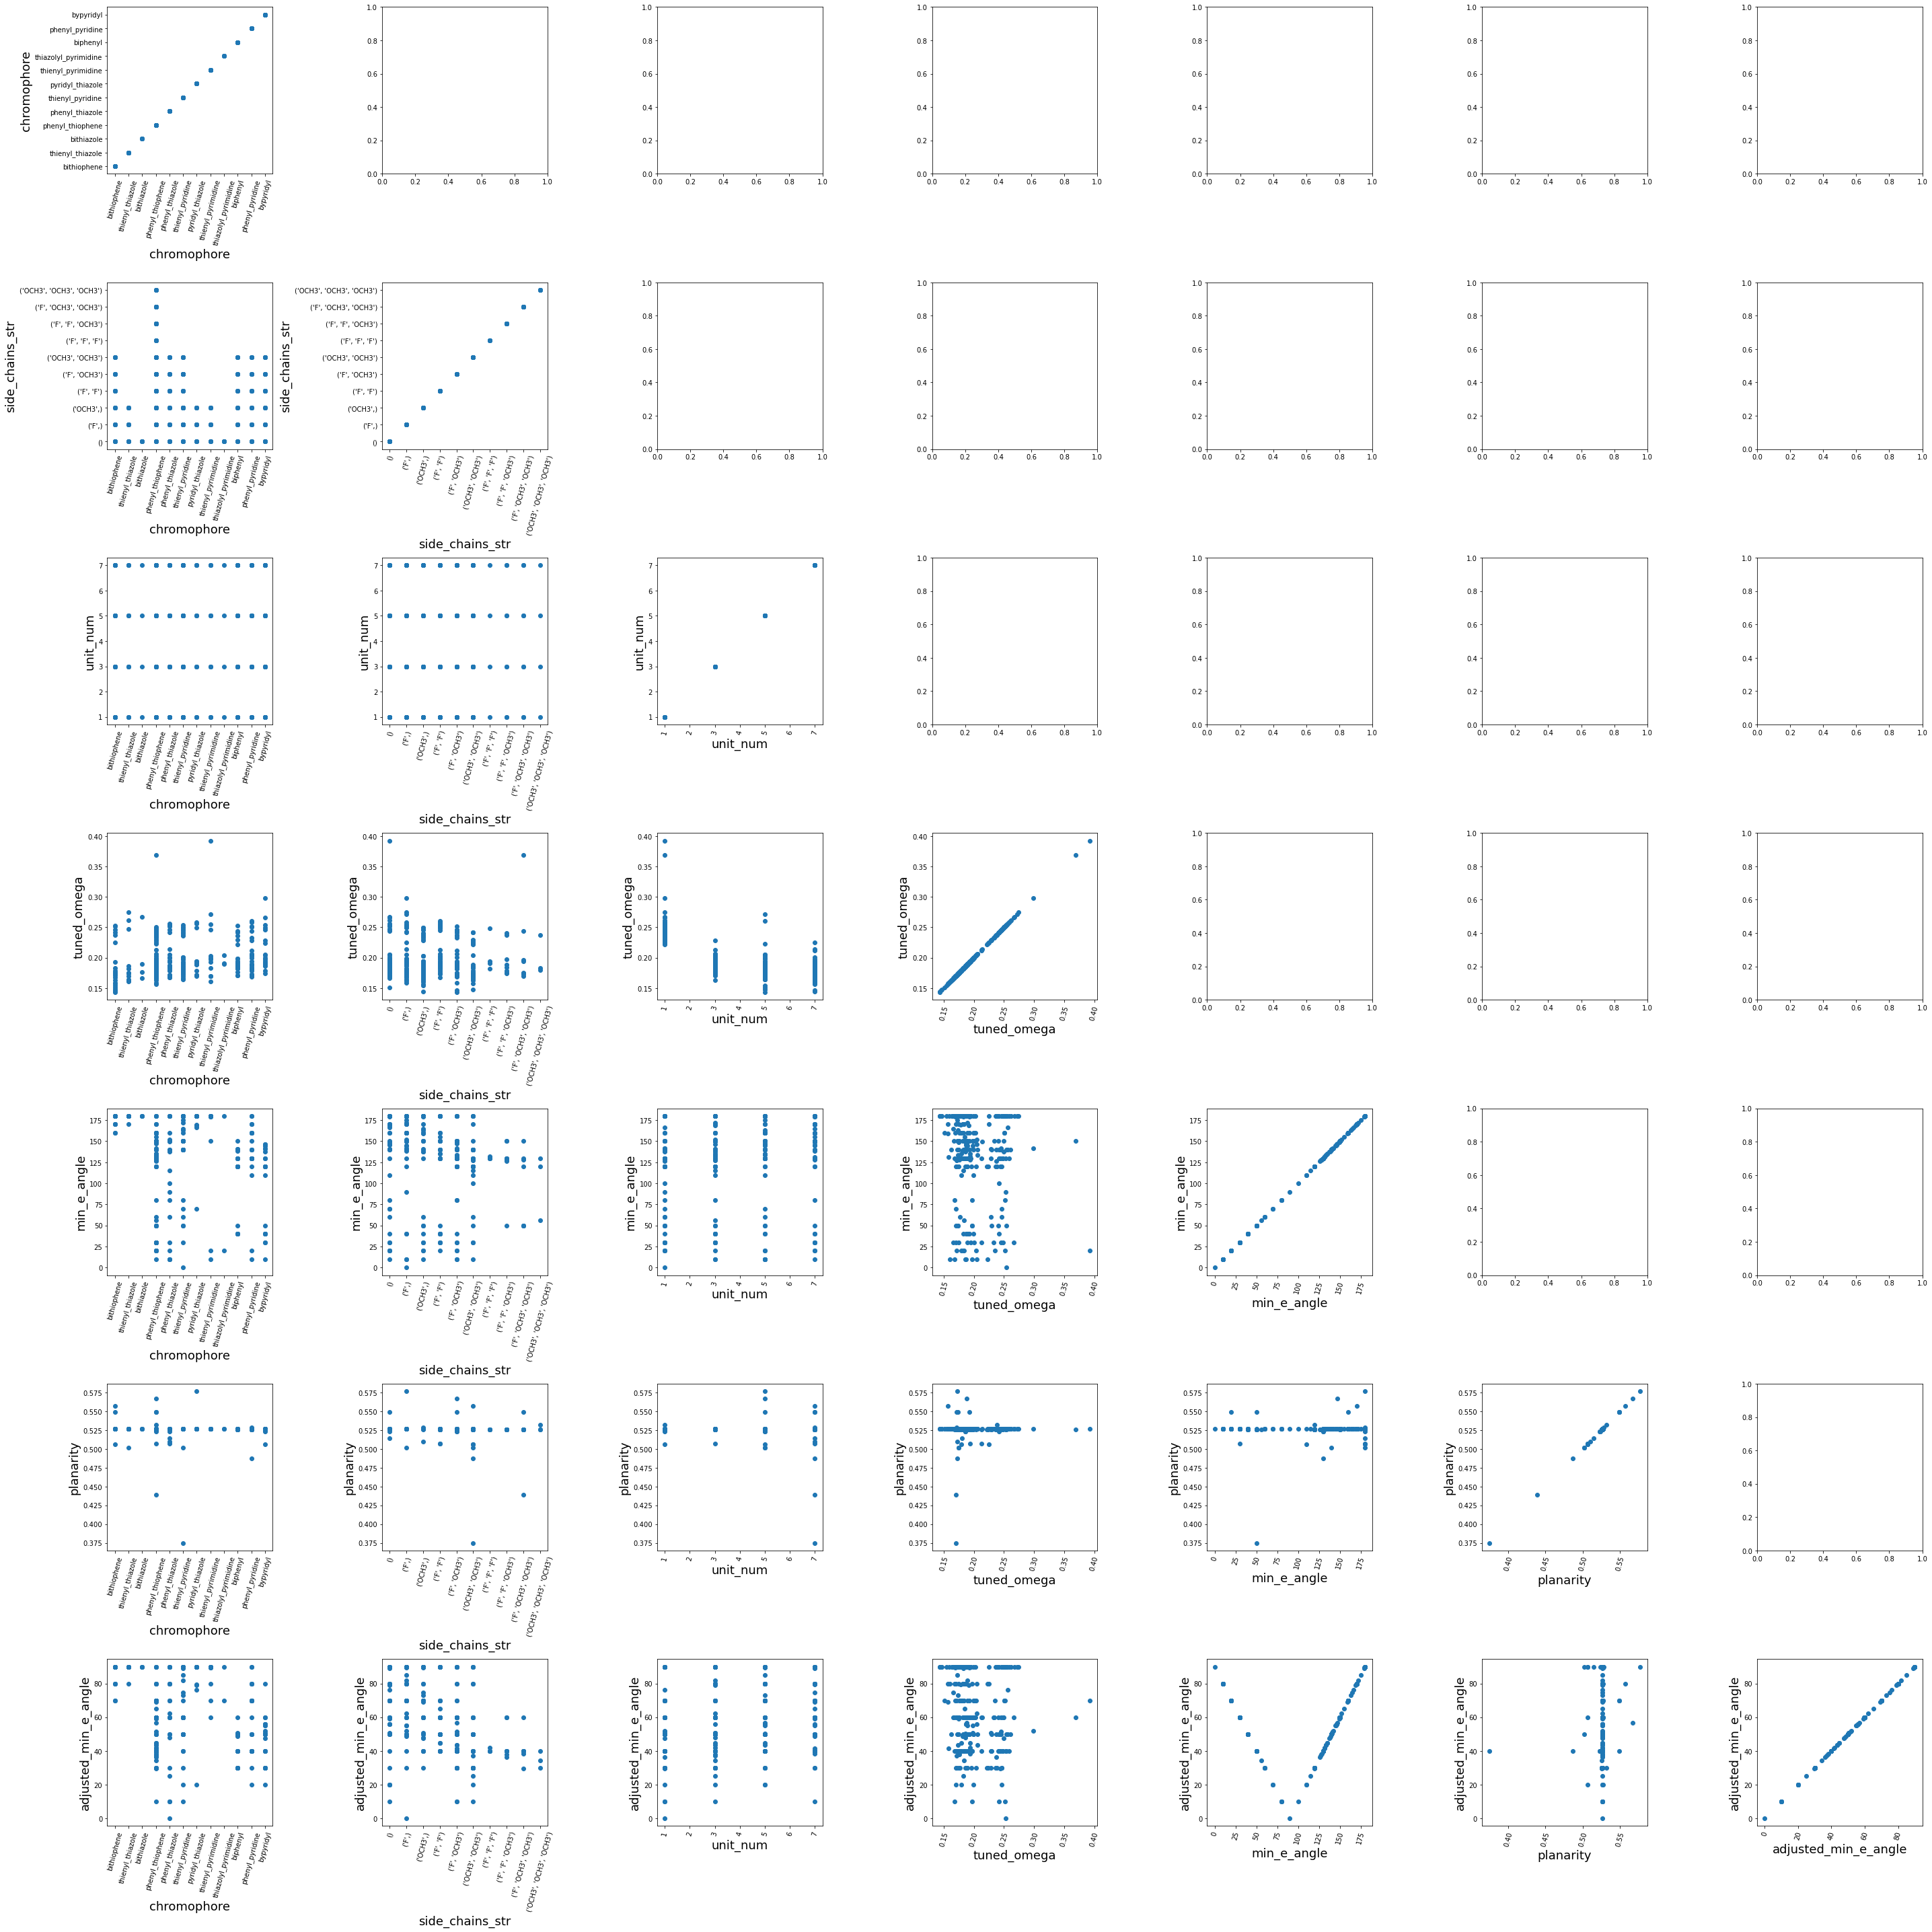

In [7]:
# Compare non-energy properties with scatter

comparing_columns = ['chromophore', 'side_chains_str', 'unit_num', 'tuned_omega', 'min_e_angle',
                     'planarity', 'adjusted_min_e_angle']
num_properties = len(comparing_columns)
fig, axes = plt.subplots(num_properties, num_properties, figsize=(40,40))
for i in range(num_properties):
    for j in range(i,num_properties):
        ax = axes[j,i]
        try: 
            x, y = comparing_columns[i], comparing_columns[j]
            ax.scatter(data[x], data[y])
            ax.set_xlabel(x, fontsize=18)
            ax.set_ylabel(y, fontsize=18)
            ax.tick_params(axis='x', labelrotation=75)
        except: 
            pass
fig.patch.set_facecolor("w")
plt.tight_layout()
fig.savefig(out_dir + 'ALL.png', dpi=300, bbox_inches='tight')

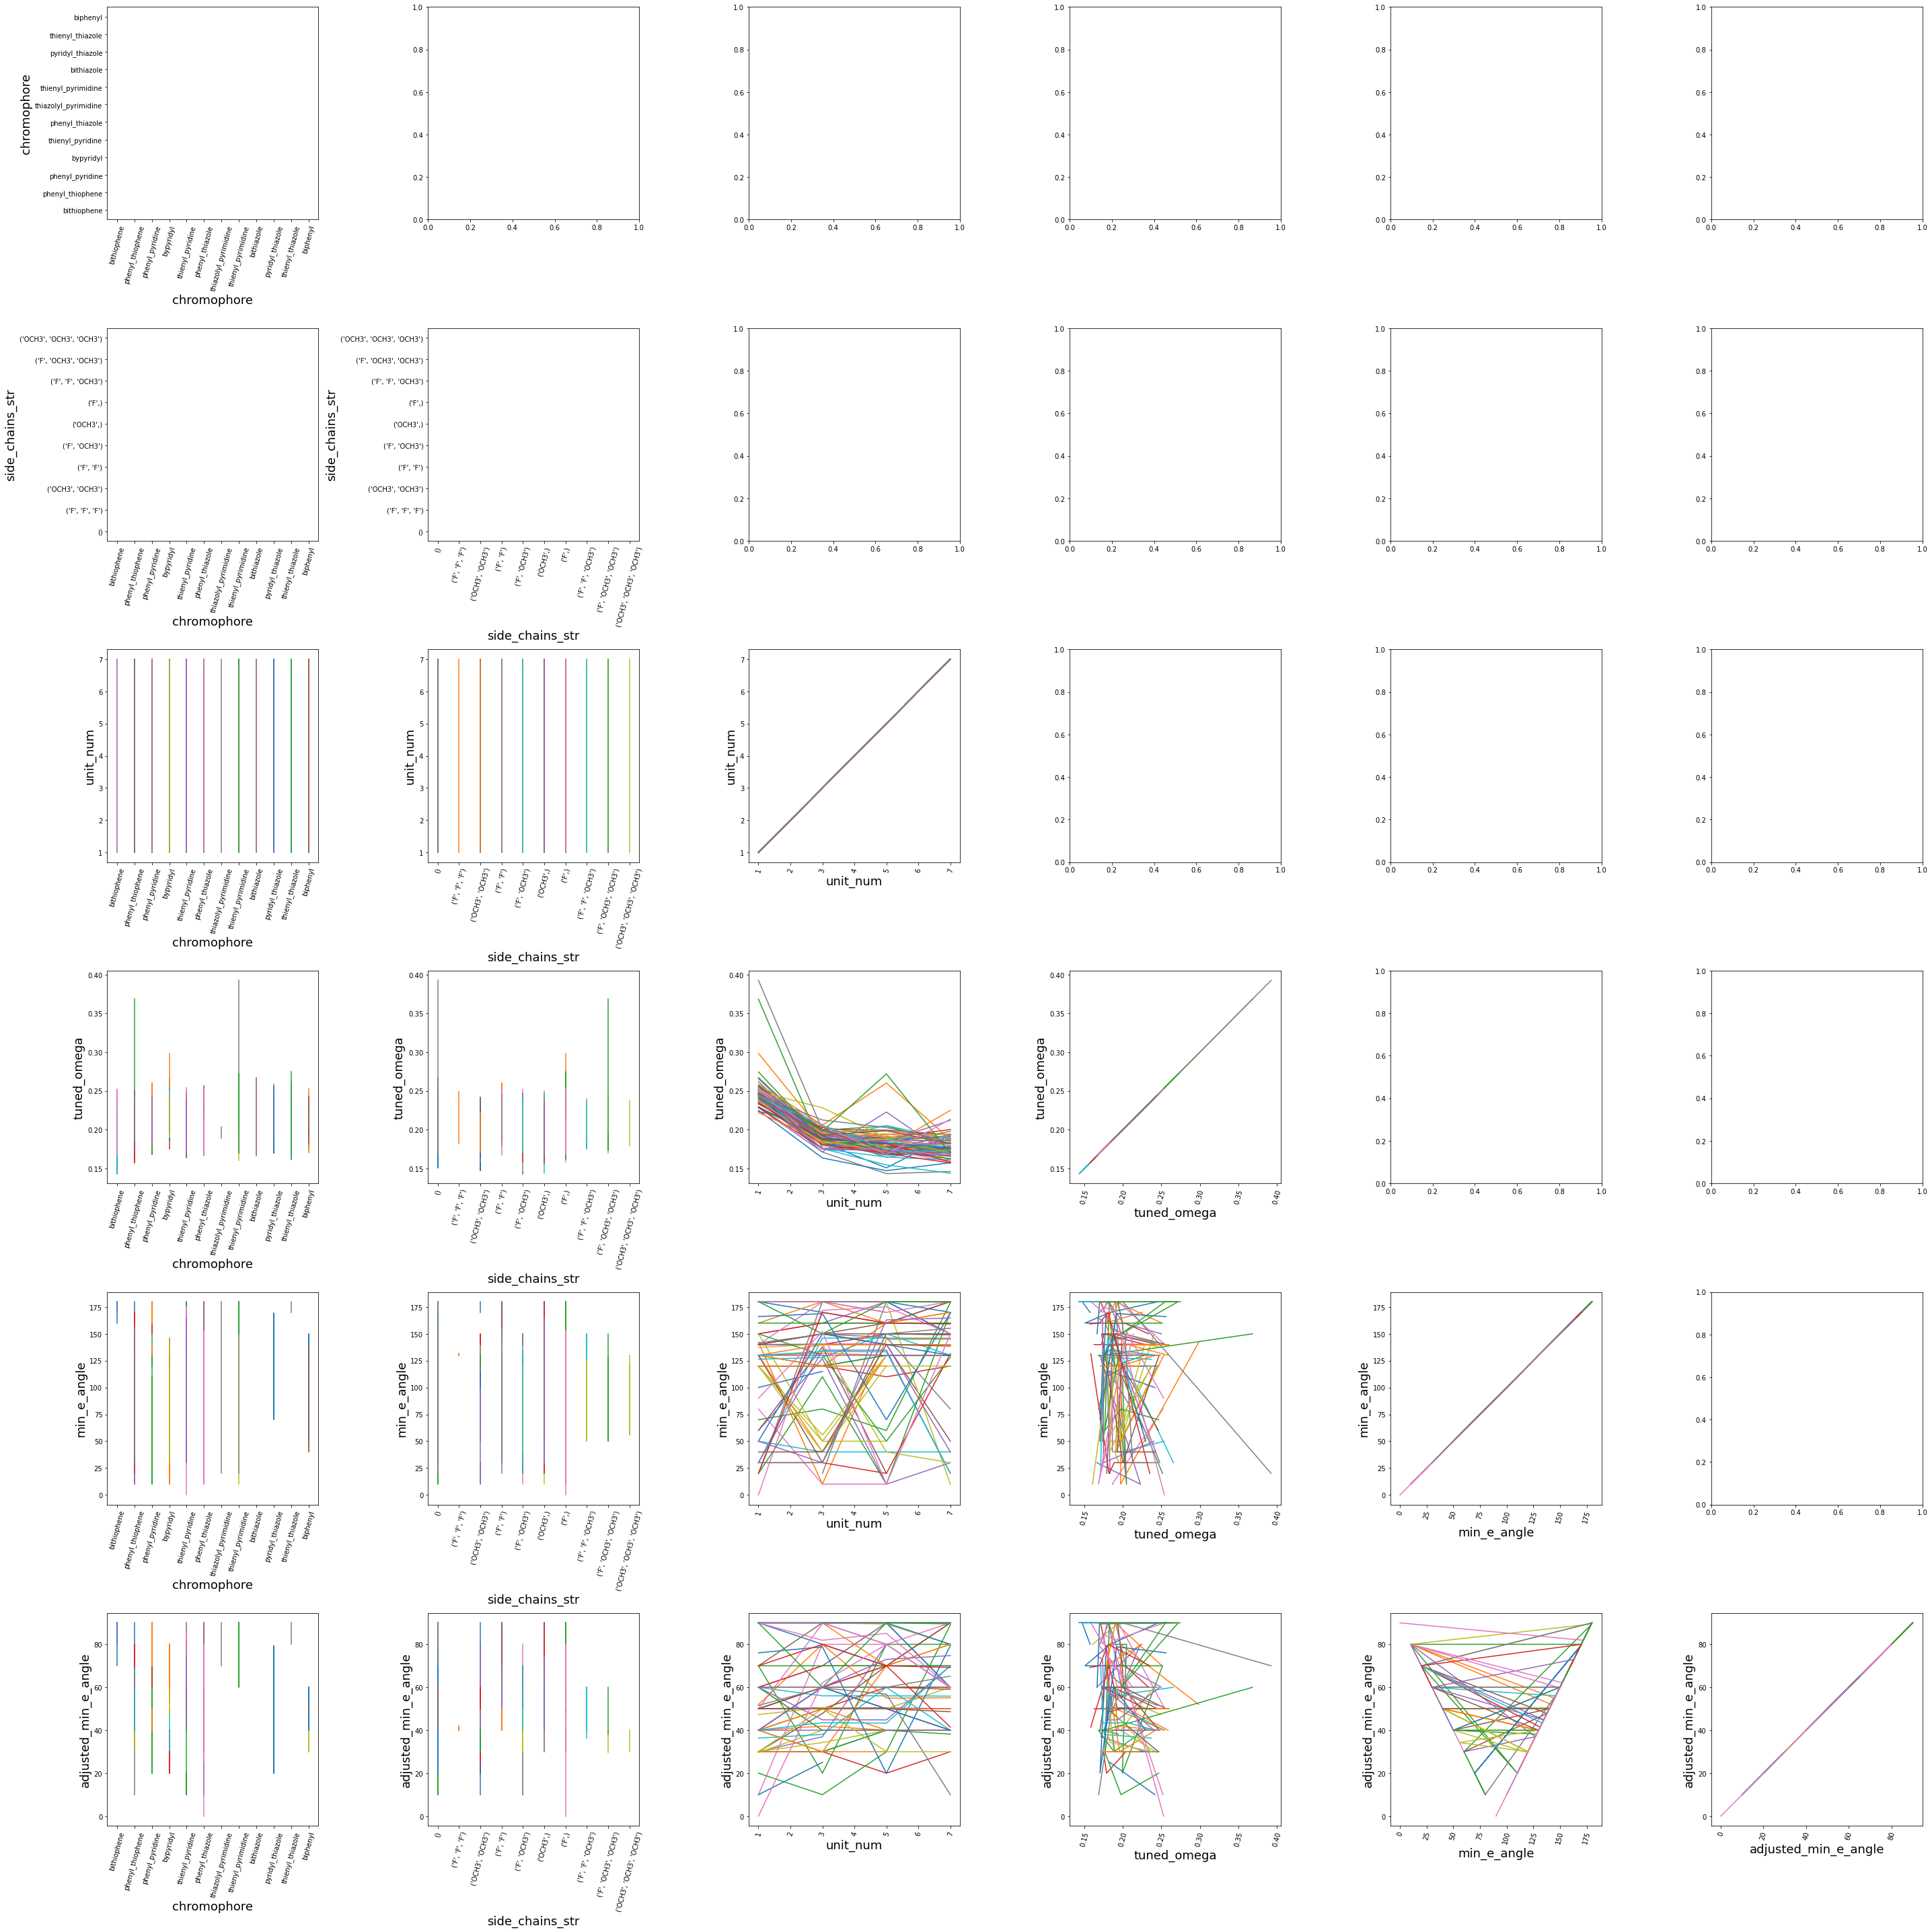

In [8]:
# Compare non-energy properties with plot 

comparing_columns = ['chromophore', 'side_chains_str', 'unit_num', 'tuned_omega', 'min_e_angle', 
                     'adjusted_min_e_angle']
molecules = set(data.molecule)

num_properties = len(comparing_columns)
fig, axes = plt.subplots(num_properties, num_properties, figsize=(40,40))
for i in range(num_properties):
    for j in range(i,num_properties):
        ax = axes[j,i]
        for mol in molecules:
            mols = data.loc[data.molecule == mol]
            mols = mols.rename(index=mols.name)
            x, y = comparing_columns[i], comparing_columns[j]
            ax.plot(mols[x], mols[y], label=mol)
            ax.set_xlabel(x, fontsize=18)
            ax.set_ylabel(y, fontsize=18)
            ax.tick_params(axis='x', labelrotation=75)
#             if i == 1: 
#                 fig.legend(bbox_to_anchor=(1.07, 1))
        
fig.patch.set_facecolor("w")
plt.tight_layout()
# fig.savefig(out_dir + 'ALL_mols.png', dpi=300, bbox_inches='tight')

In [9]:
def draw_chromophore(smiles, ax):
    rd_mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(rd_mol)
    mol_rd_image = Draw.MolToImage(rd_mol)
    mol_image = mpimg.pil_to_array(mol_rd_image)
    imagebox = OffsetImage(mol_image, zoom=0.4)
    ab = AnnotationBbox(imagebox, (90, 18), frameon=False)
    ax.add_artist(ab)
    
def make_group_plot(var_property, y_property, out_dir, figsize=(15,15)):
    properties = set(data[var_property])
    plot_len = int(np.ceil(len(properties)/4))
    fig, axes = plt.subplots(plot_len, 4, figsize=figsize, sharey=True, sharex=True)

    color_dict = {1: 'grey', 3: 'c', 5: 'm', 7: 'y'}
    for i, prop in enumerate(properties): 
        mols = data.loc[(data[var_property] == prop) & (data[y_property].notnull())]
        mols.rename(index=mols.name, inplace=True)
        ax = axes.item(i)
        ax2 = ax.twinx()
        ax.set_title(prop)
        for _, mol in mols.iterrows(): 
            if y_property == "energy":
                if mol.side_chains_str == "()" and var_property == "chromophore":
                    ax.plot(mol.energy.norm_eng, color='k')
                    if mol.unit_num == 1:
                        draw_chromophore(mol.smiles, ax)
                else: 
                    ax.plot(mol.energy.norm_eng, color=color_dict[mol.unit_num])
            elif y_property == "energy_prob":
                try:
                    ax.plot(mol.energy.norm_eng, color=color_dict[mol.unit_num])
                    ax2.plot(mol.energy.probability, color=color_dict[mol.unit_num])
#                 sns.scatterplot(data=mol.energy_prob.energy, ax=ax, color=color_dict[mol.unit_num])
#                 sns.scatterplot(data=mol.energy_prob.probability, color="orange", ax=ax2)
                except:
                    pass
            else: 
                ax.plot(mol[y_property], color=color_dict[mol.unit_num])

    fig.text(0.5, -0.01, 'Dihedral Rotation Degrees', ha='center', fontsize=18)
    fig.text(-0.01, 0.5, y_property.capitalize() + ' (kcal/mol)', va='center', rotation='vertical', fontsize=18)
    fig.text(0.3, 1.02, 'Number of Units: ', ha='center', fontsize=18)
    title = "Change in {} with Dihedral Rotation by {}".format(y_property.capitalize(), var_property.capitalize())
    fig.text(0.5, 1.07, title, ha='center', fontsize=24)
    fig.patch.set_facecolor("w")
    markers = [Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
    fig.legend(markers, color_dict.keys(), numpoints=1, fontsize=18, bbox_to_anchor=(0.75, 1.05),ncol=len(color_dict.keys()))
    fig.tight_layout()
    fig.savefig(out_dir + '{}_{}.png'.format(y_property.upper(), var_property), dpi=300, bbox_inches='tight')
    plt.close()

In [10]:
out_dir = os.path.join(plot_dir,'other/')
var_properties = ['side_chains_str', 'chromophore', 'unit_num', 'molecule']
y_properties = ['homo_lumo', 'energy']
for var_property in var_properties:
    for y_property in y_properties: 
        if var_properties == 'molecule': 
            make_group_plot(var_property, y_property, out_dir, figsize=(15,45))
        else: 
            make_group_plot(var_property, y_property, out_dir)

/home/rebekah/miniconda3/envs/my_rdkit/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/rebekah/miniconda3/envs/my_rdkit/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/rebekah/miniconda3/envs/my_rdkit/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

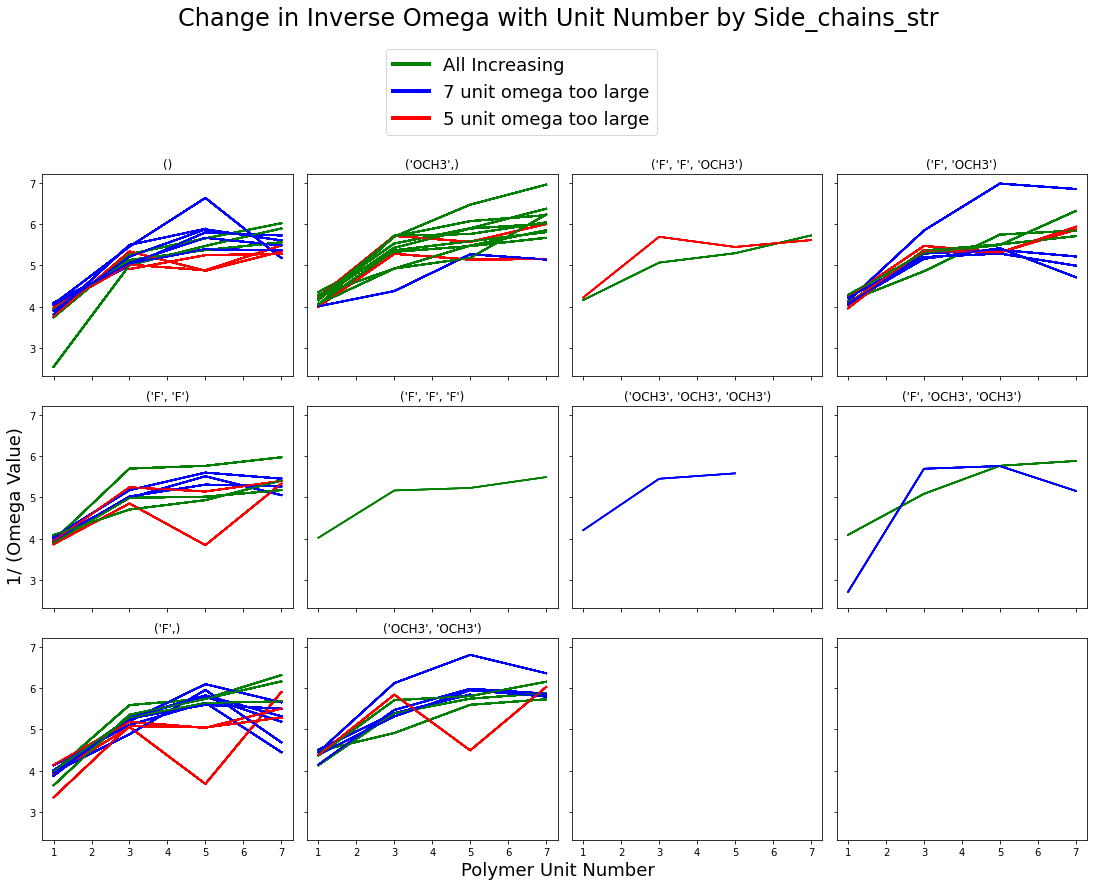

In [11]:
out_dir = os.path.join(plot_dir,'other/')
propert = 'side_chains_str'
properties = set(data[propert])

plot_len = int(np.ceil(len(properties)/4))
fig, axes = plt.subplots(plot_len, 4, figsize=(15,10), sharey=True, sharex=True)

for i, prop in enumerate(properties): 
    mols_prop = data.loc[(data[propert] == prop) & (data[propert].notnull())]
    mols_prop.rename(index=data.name, inplace=True)
    ax = axes.item(i)
    ax.set_title(prop)
    for _, mol in mols_prop.iterrows(): 
        molecules = set(mols_prop.molecule)
        for mol in molecules:
            mols = data.loc[data.molecule == mol]
            mol_type = mols.molecule_type.iloc[0]
            mols.rename(index=mols.unit_num, inplace=True)
            omega_list = [mols.at[1, 'inv_tuned_omega'], mols.at[3, 'inv_tuned_omega'], mols.at[5, 'inv_tuned_omega'], mols.at[7, 'inv_tuned_omega']]
            if all(omega_list[i] <= omega_list[i+1] for i in range(len(omega_list)-1)):
                ax.plot(mols.inv_tuned_omega, label=mol_type, color='g')
                
            elif all(omega_list[i] <= omega_list[i+1] for i in range(len(omega_list)-2)): 
                ax.plot(mols.inv_tuned_omega, label=mol_type, color='b')
                
            else: 
                ax.plot(mols.inv_tuned_omega, label=mol_type, color='r')
                

fig.text(0.5, -0.01, 'Polymer Unit Number', ha='center', fontsize=18)
fig.text(-0.01, 0.5, ' 1/ (Omega Value)', va='center', rotation='vertical', fontsize=18)
title = "Change in Inverse Omega with Unit Number by {}".format(propert.capitalize(), var_property.capitalize())
fig.text(0.5, 1.17, title, ha='center', fontsize=24)
fig.patch.set_facecolor("w")
plt.tight_layout()
custom_lines = [Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4)]
fig.legend(custom_lines, ['All Increasing', '7 unit omega too large', '5 unit omega too large'], fontsize=18, bbox_to_anchor=(0.6, 1.15))
# fig.savefig(out_dir + 'InvOmegas_{}.png'.format(propert), dpi=300, bbox_inches='tight')

Normal: 27  Bad7: 26  Bad5: 15
68


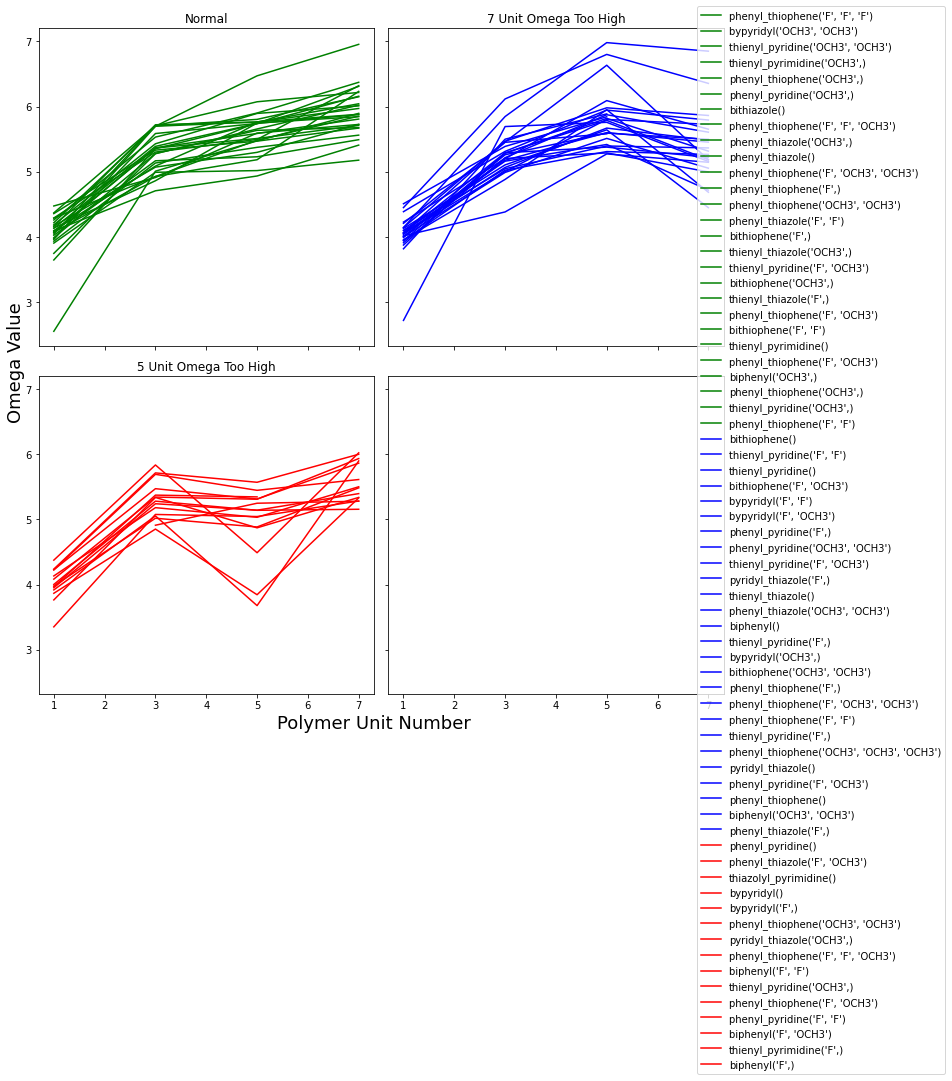

In [12]:
out_dir = os.path.join(plot_dir,'other/')
fig, axes = plt.subplots(2,2, figsize=(10,10), sharey=True, sharex=True)
ax1, ax2, ax3, ax4 = axes.flatten()
normal, bad5, bad7 = 0, 0, 0
molecules = set(data.molecule)
for mol in molecules:
    mols = data.loc[data.molecule == mol]
    mol_type = mols.molecule_type.iloc[0]
    if mols.unit_num.isnull().any(): 
        break
    mols.rename(index=mols.unit_num, inplace=True)
    omega_list = [mols.at[1, 'inv_tuned_omega'], mols.at[3, 'inv_tuned_omega'], mols.at[5, 'inv_tuned_omega'], mols.at[7, 'inv_tuned_omega']]
    if all(omega_list[i] <= omega_list[i+1] for i in range(len(omega_list)-1)):
        ax1.plot(mols.inv_tuned_omega, label=mol_type, color='g')
        ax1.set_title('Normal')
        normal +=1
    elif all(omega_list[i] <= omega_list[i+1] for i in range(len(omega_list)-2)): 
        ax2.plot(mols.inv_tuned_omega, label=mol_type, color='b')
        ax2.set_title('7 Unit Omega Too High')
        bad7 += 1
    else: 
        ax3.plot(mols.inv_tuned_omega, label=mol_type, color='r')
        ax3.set_title('5 Unit Omega Too High')
        bad5 += 1

fig.text(0.5, -0.01, 'Polymer Unit Number', ha='center', fontsize=18)
fig.text(-0.01, 0.5, 'Omega Value', va='center', rotation='vertical', fontsize=18)
fig.legend(bbox_to_anchor=(1.3, 1))
fig.patch.set_facecolor("w")
plt.tight_layout()
# fig.savefig(out_dir + 'InvOmegas_NonNormal.png'.format(propert), dpi=300, bbox_inches='tight')
print("Normal: {}  Bad7: {}  Bad5: {}".format(normal, bad7, bad5))
print(normal + bad7+bad5)

In [13]:
test_data = data.iloc[8]
test_data.energy

,energy,probability,norm_eng
0.0,5.920703,0.052612,5.920703
10.0,5.875310,0.052613,5.875310
20.0,5.771083,0.052615,5.771083
30.0,5.780646,0.052615,5.780646
40.0,5.941454,0.052612,5.941454
50.0,6.275539,0.052605,6.275539
60.0,6.756589,0.052594,6.756589
70.0,7.187377,0.052585,7.187377
80.0,7.411373,0.052580,7.411373
90.0,7.381442,0.052581,7.381442


In [14]:
if test_data.energy.energy.iloc[0] < test_data.energy.energy.iloc[-1]:
    test_data.energy['norm_eng'] = test_data.energy.energy.values[::-1]
    
test_data.energy

,energy,probability,norm_eng
0.0,5.920703,0.052612,5.920703
10.0,5.875310,0.052613,5.875310
20.0,5.771083,0.052615,5.771083
30.0,5.780646,0.052615,5.780646
40.0,5.941454,0.052612,5.941454
50.0,6.275539,0.052605,6.275539
60.0,6.756589,0.052594,6.756589
70.0,7.187377,0.052585,7.187377
80.0,7.411373,0.052580,7.411373
90.0,7.381442,0.052581,7.381442


<AxesSubplot:label='a690cf8f-1422-463f-9c00-5f44e14c52f9', ylabel='probability'>

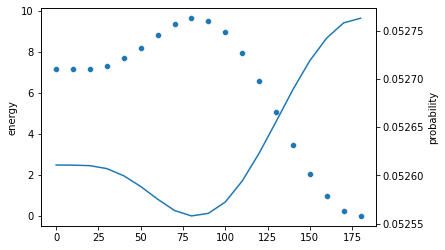

In [17]:
energy_data = data.iloc[7]
fig = plt.figure()
fig.patch.set_facecolor("w")
sns.scatterplot(data=energy_data.energy.energy)
ax2 = plt.twinx()
sns.lineplot(data=energy_data.energy.probability, ax=ax2)